# Replicated Visualizations | Visualizações replicadas

## Objective | Objetivo:
- Recreate the views as desired | Recriar as visualizações conforme desejado
- Execution of Tables 1-4 as specified (README) | Execução das Tabelas 1-4 conforme especificado (README)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import FuncFormatter
import os

# Configure styles | Configurar estilo
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (14, 7)

# Configure paths | Configurar paths
current_dir = Path.cwd()
data_dir = current_dir.parent / 'data'
processed_data_path = data_dir / 'processed' / 'casino_data_processed.csv'
reports_dir = current_dir.parent / 'reports'
reports_dir.mkdir(exist_ok=True)

In [15]:
# Load processed data | Carregar dados processados
print("Loading processed data...")
df = pd.read_csv(processed_data_path)
print(f"Total of loaded records: {len(df)}")

Loading processed data...
Total of loaded records: 3142


In [16]:
# Correct the date column | Corrigir a coluna de data
df['Month, Year'] = pd.to_datetime(df['Month, Year'], errors='coerce')
print(f"Missing dates: {df['Month, Year'].isnull().sum()}")

# Auxiliary function for currency formatting | Função auxiliar para formatação de moeda
def format_currency(x, pos):
    """Formats values in euros for display (en)
    Formata valores em euros para visualização (pt-br)"""
    return f'€{x/1000:,.0f}K' if abs(x) >= 1000 else f'€{x:,.0f}'

Missing dates: 0


# Table 1: Monthly Performance (New Players vs GGR) | Tabela 1: Desempenho Mensal (Novos Jogadores vs GGR)

In [17]:
# Calculate new players pr month (first_bet_date in the current month) | Calcular novos jogadores por mês (first_bet_date no mês atual)
try:
    df['First_Bet_Month'] = pd.to_datetime(
        df['Month of first_bet_date'], 
        format='%B',
        errors='coerce'
    )
except ValueError:
    # Se falhar, tentar conversão genérica
    df['First_Bet_Month'] = pd.to_datetime(
        df['Month of first_bet_date'], 
        errors='coerce'
    )
# Convert to monthly period | Converter para período mensal
df['First_Bet_Month'] = df['First_Bet_Month'].dt.to_period('M')

df['Month, Year'] = pd.to_datetime(
    df['Month, Year'], 
    format='%Y-%m-%d',  # Format: YYYY-MM-DD
    errors='coerce'
)

df['Month_Period'] = df['Month, Year'].dt.to_period('M')

# Identify new players | Identificar novos jogadores
valid_mask = df['First_Bet_Month'].notna() & df['Month_Period'].notna()
df.loc[valid_mask, 'Is_New_Player'] = (
    df.loc[valid_mask, 'First_Bet_Month'] == df.loc[valid_mask, 'Month_Period']
)
df.loc[~valid_mask, 'Is_New_Player'] = False

monthly_performance = df.groupby('Month_Period').agg(
    New_Players=('Is_New_Player', 'sum'),
    Total_GGR=('GGR Ucur', 'sum')
).reset_index()

monthly_performance['Month_Date'] = monthly_performance['Month_Period'].dt.to_timestamp()

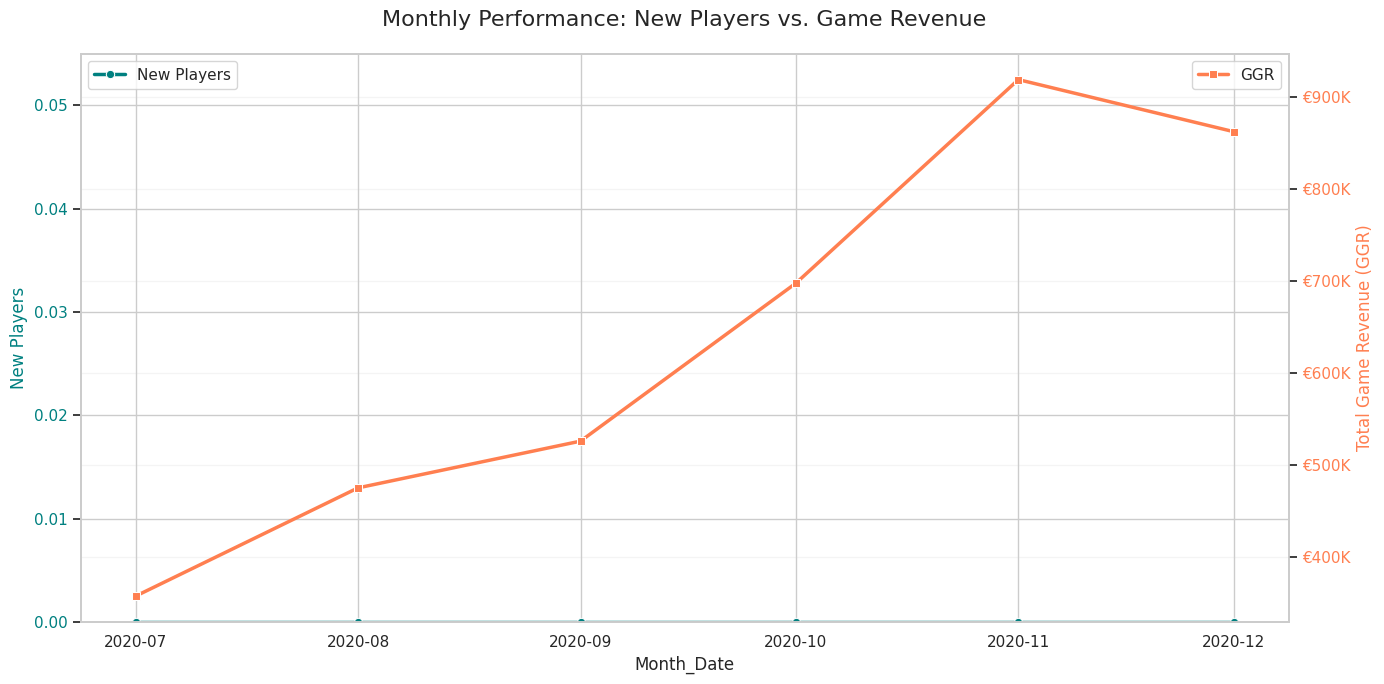

In [18]:
# Table 1 Plot | Plotar Tabela 1
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# New PLayers | Novos jogadores
sns.lineplot(data=monthly_performance, x='Month_Date', y='New_Players', 
             ax=ax1, color='teal', marker='o', linewidth=2.5, label='New Players')
ax1.set_ylabel('New Players', color='teal', fontsize=12)
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_ylim(bottom=0)

# GGR
sns.lineplot(data=monthly_performance, x='Month_Date', y='Total_GGR', 
             ax=ax2, color='coral', marker='s', linewidth=2.5, label='GGR')
ax2.set_ylabel('Total Game Revenue (GGR)', color='coral', fontsize=12)
ax2.tick_params(axis='y', labelcolor='coral')
ax2.yaxis.set_major_formatter(FuncFormatter(format_currency))

# General Configurations | Configurações gerais
plt.title('Monthly Performance: New Players vs. Game Revenue', fontsize=16, pad=20)
plt.xlabel('Month', fontsize=12)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(reports_dir / 'tabela1_monthly_performance.png', dpi=300)
plt.show()

# Table 2: Quarterly Variation | Tabela 2: Variação Trimestral

In [19]:
# Create year columns and quarters | Criar colunas de ano e trimestre
df['Year'] = df['Month, Year'].dt.year
df['Quarter'] = df['Month, Year'].dt.quarter

# Calculate quaterly metrics | Calcular métricas trimestrais
quarterly = df.groupby(['Year', 'Quarter']).agg(
    Total_GGR=('GGR Ucur', 'sum'),
    Total_Wager=('Wager Ucur', 'sum')
).reset_index()

# Calculate percentage change | Calcular variação percentual
quarterly['GGR_Pct_Change'] = quarterly['Total_GGR'].pct_change() * 100
quarterly['Wager_Pct_Change'] = quarterly['Total_Wager'].pct_change() * 100

# Create label for quarter | Criar rótulo para trimestre
quarterly['Quarter_Label'] = quarterly['Year'].astype(str) + 'T' + quarterly['Quarter'].astype(str)

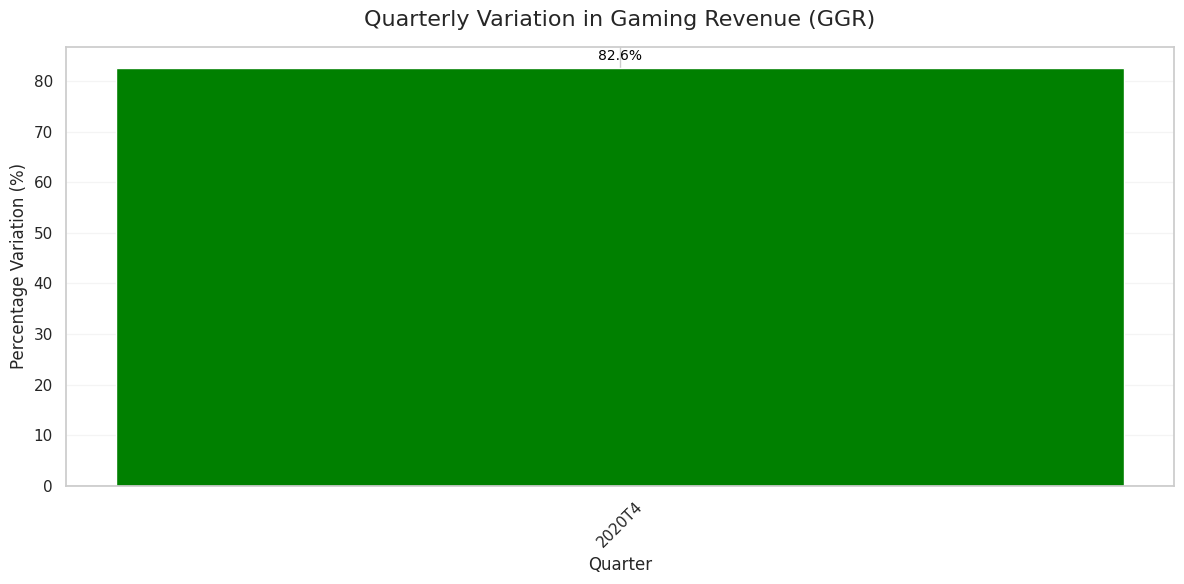

In [20]:
# Table 3 plot | Plotar Tabela 2
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in quarterly['GGR_Pct_Change']]
bars = plt.bar(quarterly['Quarter_Label'], quarterly['GGR_Pct_Change'], color=colors)

# Add value label | Adicionar rótulos de valor
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + (1 if height > 0 else -3), 
             f'{height:.1f}%', 
             ha='center', 
             va='bottom' if height > 0 else 'top',
             color='black',
             fontsize=10)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Quarterly Variation in Gaming Revenue (GGR)', fontsize=16, pad=15)
plt.ylabel('Percentage Variation (%)', fontsize=12)
plt.xlabel('Quarter', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig(reports_dir / 'tabela2_quarterly_variation.png', dpi=300)
plt.show()

# Table 3: Blackjack Analysis by Time of Day | Tabela 3: Análise de Blackjack por Período do Dia

In [23]:
# Prepare specific data for Blackjack | Preparar dados específicos para Blackjack
blackjack_df = df[df['Game category'] == 'Blackjack'].copy()

# Simulate time data (since we do not have it in the original data) | Simular dados de horário (já que não temos nos dados originais)
np.random.seed(42)
blackjack_df['Hour'] = np.random.randint(0, 24, size=len(blackjack_df))

# Classify as morning or afternoon | Classificar como manhã ou tarde
blackjack_df['Time_Period'] = np.where(
    blackjack_df['Hour'] < 12, 
    'Morning (00:00-11:59)', 
    'Afternoon (12:00-23:59)'
)

# Group by period and table type | Agrupar por período e tipo de mesa
blackjack_grouped = blackjack_df.groupby(['Time_Period', 'Table_Type_Simplified']).size().unstack()

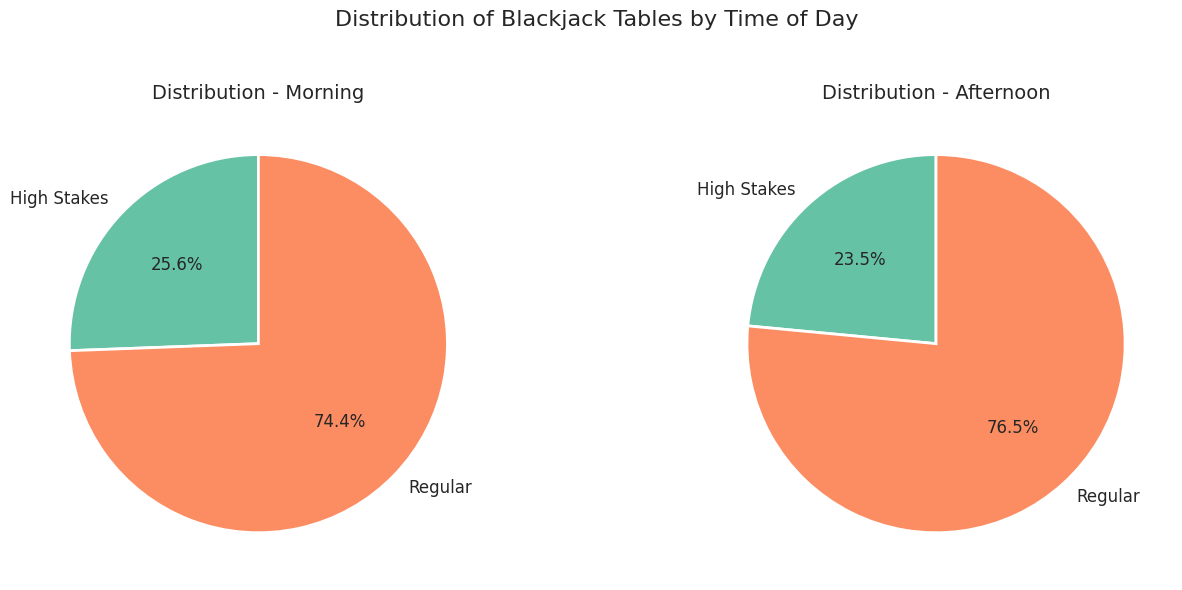

In [24]:
# Table 3 Plot | Plotar Tabela 3
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Morning | Manhã
blackjack_grouped.loc['Morning (00:00-11:59)'].plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90,
    colors=['#66c2a5', '#fc8d62'],
    wedgeprops={'edgecolor': 'w', 'linewidth': 2},
    textprops={'fontsize': 12}
)
axes[0].set_ylabel('')
axes[0].set_title('Distribution - Morning', fontsize=14)

# Afternoon | Tarde
blackjack_grouped.loc['Afternoon (12:00-23:59)'].plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90,
    colors=['#66c2a5', '#fc8d62'],
    wedgeprops={'edgecolor': 'w', 'linewidth': 2},
    textprops={'fontsize': 12}
)
axes[1].set_ylabel('')
axes[1].set_title('Distribution - Afternoon', fontsize=14)

plt.suptitle('Distribution of Blackjack Tables by Time of Day', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(reports_dir / 'tabela3_blackjack_time.png', dpi=300)
plt.show()

## Table 4: Category Ranking by Country | Tabela 4: Ranking de Categorias por País

In [25]:
# Calculate GGR by Country and Category | Calcular GGR por país e categoria
country_cat = df.groupby(['Country', 'Game category'])['GGR Ucur'].sum().reset_index()

# Create ranking | Criar ranking
country_cat['Rank'] = country_cat.groupby('Country')['GGR Ucur'].rank(ascending=False, method='dense')

# Filter top 3 by country | Filtrar top 3 por país
top_country_cat = country_cat[country_cat['Rank'] <= 3].sort_values(['Country', 'Rank'])

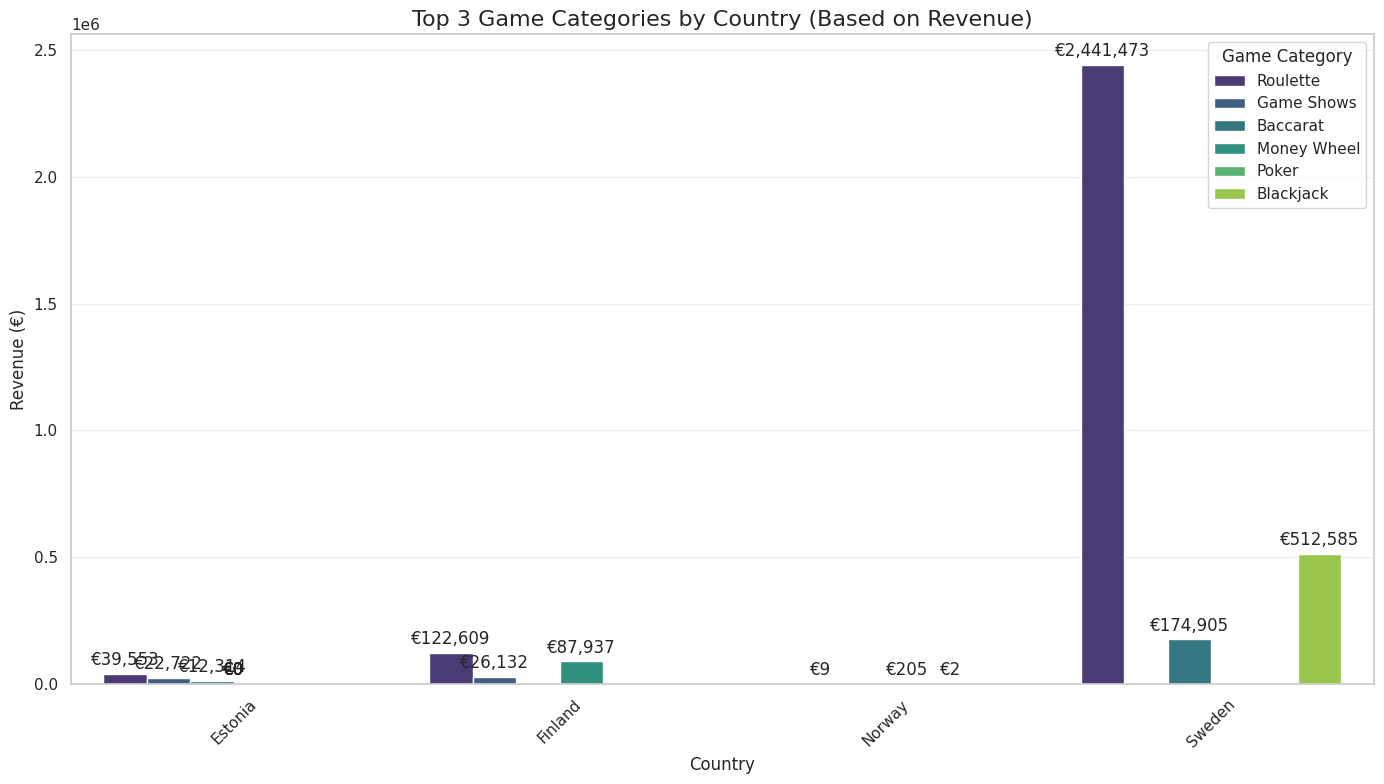

In [26]:
# Plot Table 4 with Matplot | Plotar Tabela 4 com Matplot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_country_cat,
    x='Country',
    y='GGR Ucur',
    hue='Game category',
    palette='viridis',
    estimator=sum
)

plt.title('Top 3 Game Categories by Country (Based on Revenue)', fontsize=16)
plt.ylabel('Revenue (€)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add the values on the bars | Adicionar valores nas barras
for p in plt.gca().patches:
    plt.gca().annotate(
        f'€{p.get_height():,.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points'
    )

plt.legend(title='Game Category', loc='upper right')
plt.tight_layout()
plt.savefig(reports_dir / 'tabela4_categories_ranking.png', dpi=300)
plt.show()